In [1]:
import json
import csv
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from web3.auto import w3
from web3.logs import STRICT, IGNORE, DISCARD, WARN
from eth_abi import decode_single, decode_abi

from compounds_research import settings

In [5]:
w3.HTTPProvider('http:satoshi.doc.ic.ac.uk:8545')

In [3]:
# dydx margin solo contract
dydx_solo = '0x1E0447b19BB6EcFdAe1e4AE1694b0C3659614e4e'

In [6]:
with open(path.join(settings.PROJECT_ROOT, 'misc', 'dydx-solo-abi.json')) as json_file:
    solo_abi = json.load(json_file)

In [7]:
contract = w3.eth.contract(address=dydx_solo, abi=solo_abi['contracts']['contract.sol:Events']['abi'])

In [8]:
tokens = {
    'DAI': '0x6B175474E89094C44Da98b954EedeAC495271d0F',
    'WETH': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
    'SAI': '0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359',
    'USDC': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'
}

dydx_market_ids = {
    'DAI': 3,
    'WETH': 0,
    'SAI': 1,
    'USDC': 2
}

In [29]:
blocktimes = pd.read_csv(path.join(settings.DATA_PATH, 'dydx', 'eth_block_times.csv.gz'))

def load_data(filename: str):
    df = pd.read_csv(path.join(settings.DATA_PATH, 'dydx', filename))
    df = df.set_index('block_height').join(blocktimes.set_index('block_height'))
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    del df['timestamp']
    return df

In [27]:
df_dai = load_data('dai_market_dydx.csv.gz')
df_weth = load_data('weth_market_dydx.csv.gz')
df_usdc = load_data('usdc_market_dydx.csv.gz')


In [30]:
def plot_rate(df, title=None):
    seconds_per_year = 3600 * 24 * 365
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    lns1 = ax1.plot(df['datetime'], df['interest_rate']/1e18 * seconds_per_year, color='steelblue', label='Interest Rate')
    lns2 = ax2.plot(df['datetime'], df['utilization'], linestyle=':', color='lightsteelblue', label='Utilization')
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs)
    if title is not None:
        ax1.set_title(title)
    
    ax1.set_ylabel('Borrow Interest Rate (APR)')
    ax1.set_xlabel('Block Number')
    ax2.set_ylabel('Utilization')

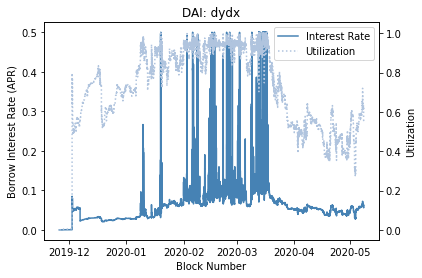

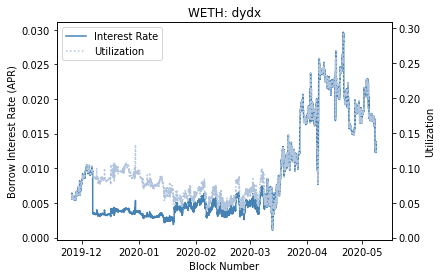

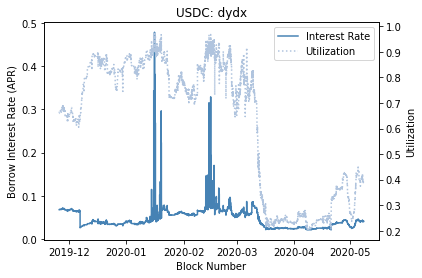

In [31]:
plot_rate(df_dai, title='DAI: dydx')
plot_rate(df_weth, title='WETH: dydx')
plot_rate(df_usdc, title='USDC: dydx')


In [31]:
def getInterestRates(token, fromBlock=9000000, toBlock=w3.eth.blockNumber, file='_dydx.csv'):
    assert fromBlock <= toBlock, 'Invalid block range specified.'
    dydx = w3.eth.contract(address=dydx_solo, abi=solo_abi['contracts']['contract.sol:Getters']['abi'])
    market_id = dydx_market_ids[token.upper()]
    token_address = tokens[token.upper()]
    height = fromBlock
    
    with open(token.lower()+'_'+file, 'w', newline='') as csvfile:
        fieldnames = ['block_height', 'token_address', 'interest_rate', 'borrow_amount', 'supply_amount', 'utilization']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
        while height <= toBlock:
            market_info = dydx.functions.getMarketWithInfo(market_id).call(block_identifier=height)
            assert tokens[token] == market_info[0][0]
            interest_rate = market_info[3][0]
            borrow = market_info[0][1][0]
            supply = market_info[0][1][1]
            utilization = round(borrow/supply, 5) if supply != 0 else 0
            writer.writerow({
                'block_height': height, 
                'token_address': token_address, 
                'interest_rate': interest_rate,
                'borrow_amount': borrow,
                'supply_amount': supply,
                'utilization': utilization
            })
            #print(height, interest_rate, borrow, supply, utilization)
            height += 1

In [ ]:
def write_block_times(fromBlock=9000000, toBlock=w3.eth.blockNumber, file='eth_block_times.csv'):
    assert fromBlock <= toBlock, 'Invalid block range specified.' 
    with open(file, 'w', newline='') as csvfile:
        fieldnames = ['block_height', 'timestamp']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        counter = 0
        while fromBlock <= toBlock:
            timestamp = w3.eth.getBlock(fromBlock)['timestamp']
            if counter % 10000 == 0:
                #print(round(counter/(toBlock-fromBlock)*100, 2), '% of blocks parsed')
            writer.writerow({
                    'block_height': fromBlock, 
                    'timestamp': timestamp
            })
            fromBlock += 1
            counter += 1

In [ ]:
solo_abi['contracts']

In [8]:
#eventFilter = contract.events.LogIndexUpdate.createFilter(fromBlock=9948410, toBlock=9949910)
eventFilter = contract.events.LogIndexUpdate.createFilter(fromBlock=9948410, toBlock=9949910)
w3.eth.getFilterLogs(eventFilter.filter_id)

In [ ]:
decode_single('(uint256,uint256,bool,uint256,bool,uint128,address)', bytes.fromhex('00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000037e2597f4e24462d00000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000004616280dd3afccf5000000000000000000000000a8b39829ce2246f89b31c013b8cde15506fb9a76'))